In [14]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy
import import_ipynb
import GP_util #load module first
import importlib
importlib.reload(GP_util) # reload full module
from GP_util import unique, select, fastdistancematrix,linear_pixel
#import methods from reloaded module

importing Jupyter notebook from GP_util.ipynb


In [7]:
datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_24.csv'
df = pd.read_csv(datapath)

df = select(df, n=200) # selects subset of df for time/memory reductions

In [8]:
f, df_unique, zero_farm_idx, Num_farms = unique(df)

there are 195 unique farms in loaded df


In [15]:
distance, Dmatsq = fastdistancematrix(df, distance_calc=True)

In [16]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    l = pm.Gamma('l', alpha = 3, beta=.01)
    #l = pm.HalfCauchy('l', 100)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-2
    Kij = etasq*(np.exp(-Dmatsq/l**2)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, l, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [08:00<00:00,  4.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 3,6) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    lsq = pm.Gamma('lsq', alpha = 3.5, beta=1.2e-5)
    #l = pm.HalfCauchy('l', 100)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-1
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace_lsq = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, lsq, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [05:36<00:00,  5.36draws/s]
The acceptance probability does not match the target. It is 0.9010556400446182, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


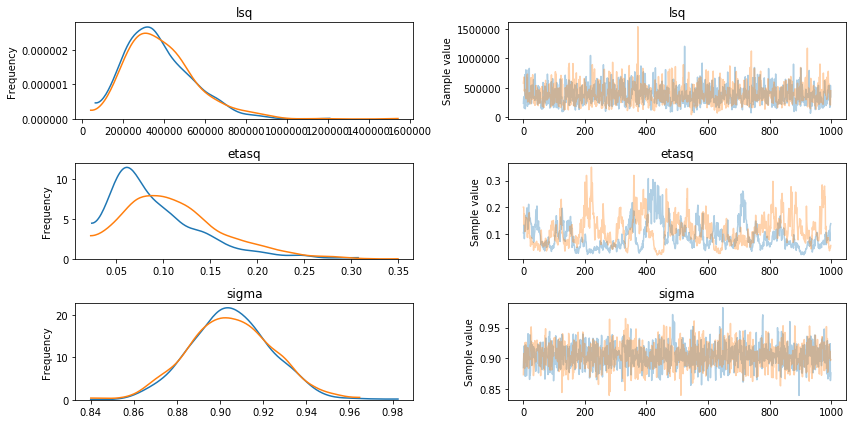

In [39]:
pm.traceplot(trace_lsq, varnames=['lsq','etasq','sigma']);

In [40]:
pm.summary(trace_lsq,varnames=['sigma','lsq','etasq'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.904791,0.019061,0.000504,0.867396,0.940828,1534.895247,0.999560
lsq,379587.629461,164211.482354,4540.131535,96987.180379,693846.328159,1219.531967,1.001744
etasq,0.103934,0.052880,0.004217,0.024194,0.208121,55.891474,1.036423


In [20]:
pm.summary(trace,varnames=['sigma','l','etasq'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.907187,0.017889,0.000392,0.870660,0.943028,2181.219890,1.001005
l,669.516649,227.377745,12.934764,278.133061,1119.909394,189.875046,1.000343
etasq,0.243013,0.151535,0.013159,0.039683,0.518645,52.199472,1.014662


In [44]:
with pm.Model() as GP_uncentered:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    lsq = pm.Gamma('lsq', alpha = 3.5, beta=1.2e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    #ls = pm.Gamma('ls',alpha=3, beta=.01)
    #ls = pm.HalfCauchy('ls', 200)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    
    sigmay = 1e-2
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
    
    # ========== gaussian process informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    # to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z))
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    #trace_uc = pm.sample(1000,tune=100,chains=2,nuts_kwargs={'target_accept': .95})
    trace_lsq = pm.sample(1000,chains=2)

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, z, lsq, etasq]
Sampling 2 chains: 100%|██████████| 3000/3000 [05:46<00:00,  8.76draws/s]


In [42]:
pm.summary(trace_n,varnames=['sigma','ls','etasq'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.907571,0.019459,0.000328,0.871908,0.946806,3339.401425,0.999796
ls,639.530742,215.412638,7.668195,226.510518,1019.987582,683.847897,1.001164
etasq,0.241144,0.130059,0.003354,0.043204,0.488859,1519.679828,0.999523


In [49]:
d = pd.DataFrame(pm.summary(trace_lsq,varnames=['sigma','lsq','etasq']))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.907573,0.018986,0.000325,0.872278,0.946219,4165.089563,0.999964
lsq,445862.675638,181030.257502,3842.654026,131197.263675,799555.265384,2019.255567,0.999717
etasq,0.244329,0.129557,0.003324,0.055977,0.513236,1251.176582,1.005003


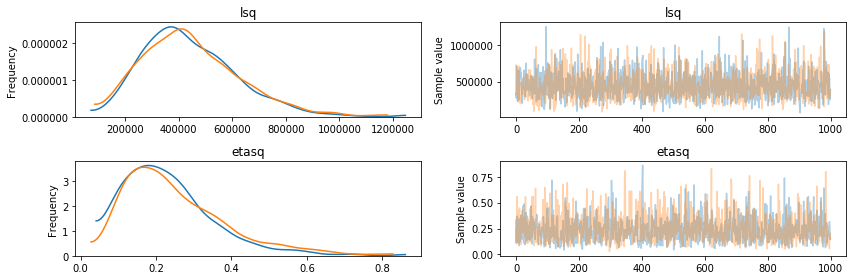

In [47]:
pm.traceplot(trace_lsq,varnames=['lsq','etasq']);

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 's'
  s)


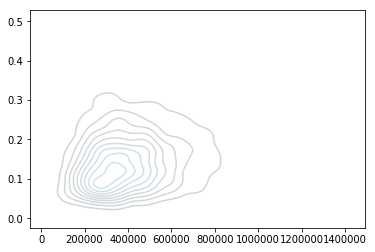

In [37]:
sns.kdeplot(trace_lsq['lsq'], trace_lsq['etasq'], s=2, alpha=.2);


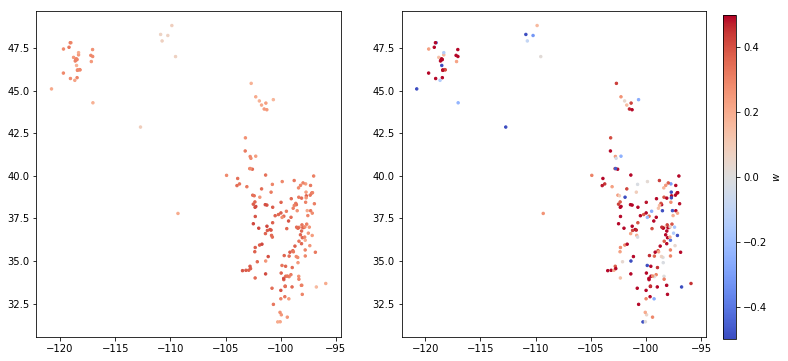

In [31]:
v = .5
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12,6))
im = ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=df_unique.B_zprsum3,
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label='$w$');

No handles with labels found to put in legend.


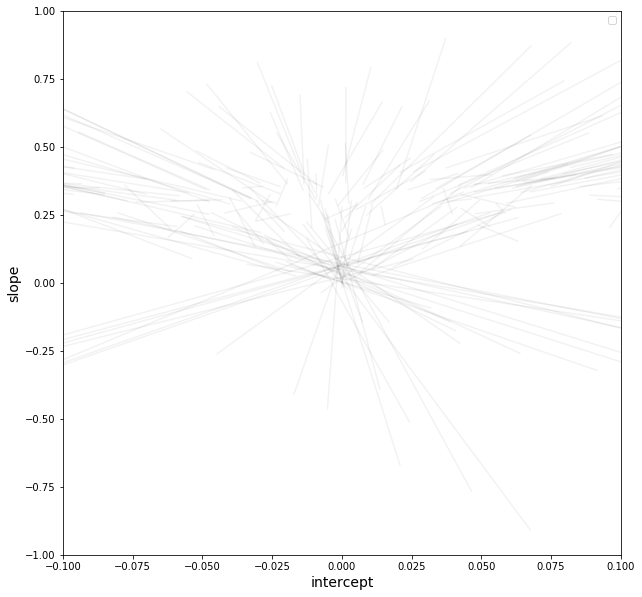

In [33]:
b1 = trace_lsq['w'].mean(axis=0)
a1 = trace_lsq['a'].mean(axis=0)

a2 = df_unique['a_zprsum3']
b2 = df_unique['B_zprsum3']

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.scatter(a0,b0,label='Ordinary Least Squares', s=10)
#ax.scatter(a2, b2, label='OLS', c='k',s=5, alpha=.4)
#ax.scatter(a1, b1, label='Gaussian Process', s=5, alpha=1)



#ax.plot([a1, a0], [b1, b0], 'k-', alpha=.05)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.05)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
#ax.set_title('studentT = .3 vs. studentT sigma=RV')
ax.set_xlim(-.1,.1)
ax.set_ylim(-1,1)
ax.legend();

In [28]:
df_unique['B_zprsum3'] = 0
df_unique['a_zprsum3'] = 0
column_x='zprsum3'
for i,p in enumerate(df_unique.index):
    mu,C = linear_pixel(df, p, column_x=column_x,column_y='zNDVIsum3', c=None,cluster=False)
    df_unique.loc[(df_unique.index == p),'B_' + column_x] = mu[1]
    df_unique.loc[(df_unique.index == p),'a_' + column_x] = mu[0]

In [144]:
import scipy
Kij_sparse = scipy.sparse.csr_matrix(Kij)

In [145]:
Kij_sparse

<98x98 sparse matrix of type '<class 'numpy.float64'>'
	with 9604 stored elements in Compressed Sparse Row format>

In [147]:
pm.sample?
